<a href="https://colab.research.google.com/drive/1LH4HinVwLGL-gYXot2zkoCIdxtMMI5N_" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/JunHL96/PyTorch-Course/blob/main/04_pytorch_custom_datasets_notes.ipynb) | [View Slides](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/04_pytorch_custom_datasets.pdf) | [Watch Video Walkthrough](https://youtu.be/Z_ikDlimN6A?t=71010)

# 04. PyTorch Custom Datasets



In the last notebook, [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/), we looked at how to build computer vision models on an in-built dataset in PyTorch (FashionMNIST).

The steps we took are similar across many different problems in machine learning.

Find a dataset, turn the dataset into numbers, build a model (or find an existing model) to find patterns in those numbers that can be used for prediction.

PyTorch has many built-in datasets used for a wide number of machine learning benchmarks, however, you'll often want to use your own **custom dataset**.

## What is a custom dataset?



A **custom dataset** is a collection of data relating to a specific problem you're working on.

In essence, a **custom dataset** can be comprised of almost anything.

For example, if we were building a food image classification app like [Nutrify](https://nutrify.app), our custom dataset might be images of food.

Or if we were trying to build a model to classify whether or not a text-based review on a website was positive or negative, our custom dataset might be examples of existing customer reviews and their ratings.

Or if we were trying to build a sound classification app, our custom dataset might be sound samples alongside their sample labels.

Or if we were trying to build a recommendation system for customers purchasing things on our website, our custom dataset might be examples of products other people have bought.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-domain-libraries.png" alt="different pytorch domain libraries can be used for specific PyTorch problems" width=1000/>

*PyTorch includes many existing functions to load in various custom datasets in the [`TorchVision`](https://pytorch.org/vision/stable/index.html), [`TorchText`](https://pytorch.org/text/stable/index.html), [`TorchAudio`](https://pytorch.org/audio/stable/index.html) and [`TorchRec`](https://pytorch.org/torchrec/) domain libraries.*

But sometimes these existing functions may not be enough.

In that case, we can always subclass `torch.utils.data.Dataset` and customize it to our liking.

## What we're going to cover



We're going to be applying the PyTorch Workflow we covered in [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/) and [notebook 02](https://www.learnpytorch.io/02_pytorch_classification/) to a computer vision problem.

But instead of using an in-built PyTorch dataset, we're going to be using our own dataset of pizza, steak and sushi images.

The goal will be to load these images and then build a model to train and predict on them.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png" alt="building a pipeline to load in food images and then building a pytorch model to classify those food images" width=800 />

*What we're going to build. We'll use `torchvision.datasets` as well as our own custom `Dataset` class to load in images of food and then we'll build a PyTorch computer vision model to hopefully be able to classify them.*

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **0. Importing PyTorch and setting up device-agnostic code** | Let's get PyTorch loaded and then follow best practice to setup our code to be device-agnostic.  |
| **1. Get data** | We're going to be using our own **custom dataset** of pizza, steak and sushi images. |
| **2. Become one with the data (data preparation)** | At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have. |
| **3. Transforming data** |Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to *transform* our images so they're ready to be used with a model. |
| **4. Loading data with `ImageFolder` (option 1)** | PyTorch has many in-built data loading functions for common types of data. `ImageFolder` is helpful if our images are in standard image classification format. |
| **5. Loading image data with a custom `Dataset`** | What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of `torch.utils.data.Dataset`. |
| **6. Other forms of transforms (data augmentation)** | Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of `torchvision`'s in-built data augmentation functions. |
| **7. Model 0: TinyVGG without data augmentation** | By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model. |
| **8. Exploring loss curves** | Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if your model is **underfitting** or **overfitting**. |
| **9. Model 1: TinyVGG with data augmentation** | By now, we've tried a model *without*, how about we try one *with* data augmentation? |
| **10. Compare model results** | Let's compare our different models' loss curves and see which performed better and discuss some options for improving performance. |
| **11. Making a prediction on a custom image** | Our model is trained to on a dataset of pizza, steak and sushi images. In this section we'll cover how to use our trained model to predict on an image *outside* of our existing dataset. |

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.5.1+cu121'

And now let's follow best practice and setup device-agnostic code.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`. If you do this, your runtime will likely reset and you'll have to run all of the cells above by going `Runtime -> Run before`.

In [2]:
# Device-Agnostic Code
if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps" # Apple GPU
else:
    device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

print(f"Using device: {device}")

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.5.1+cu121


## 1. Acquire Data

To begin, we need a dataset. Fortunately, some data has already been prepared for us.

We'll start with a small subset because our goal isn't to train the largest model or use the biggest dataset initially. Machine learning is an iterative process: start small, achieve functionality, then scale up as needed.

We will use a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/). Food101 is a well-known computer vision benchmark containing 101,000 images of 101 different food categories (75,750 for training and 25,250 for testing).

Instead of working with all 101 food classes, we'll focus on three: pizza, steak, and sushi. Additionally, we'll use a random 10% of the images per class to keep the dataset manageable.

If you're interested in the data sources, refer to the following resources:
* [Original Food101 Dataset and Paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)
* [`torchvision.datasets.Food101`](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) - The version used in this notebook.
* [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) - Notebook used to format the Food101 dataset for this project.
* [`data/pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) - Zip archive containing the selected images.

Next, we'll write code to download the formatted data from GitHub.

> **Note:** While the dataset we're using has been pre-formatted for our purposes, you will often need to format your own datasets to suit your specific problems. This is a common practice in the machine learning field.

In [3]:
import requests  # Import the requests library to handle HTTP requests
import zipfile   # Import the zipfile module to work with ZIP archives
from pathlib import Path  # Import Path from pathlib for easy path manipulations

# Setup path to data folder
data_path = Path("data/")  # Define the base data directory
image_path = data_path / "pizza_steak_sushi"  # Define the path for the specific image dataset

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir(): # is_dir will return True if the directory exists
    print(f"{image_path} directory exists.")  # Inform the user that the directory already exists
else:
    print(f"Did not find {image_path} directory, creating one...")  # Inform the user that the directory is missing
    image_path.mkdir(parents=True, exist_ok=True)  # Create the directory, including any necessary parent directories

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f: # wb means "write binary", f is for "file"
        # Send a GET request to download the ZIP file containing the dataset
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip") # the url where file is located
        print("Downloading pizza, steak, sushi data...")  # Notify the user that the download has started
        f.write(request.content)  # Write the downloaded content to the ZIP file

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")  # Notify the user that extraction has started
        zip_ref.extractall(image_path)  # Extract all contents of the ZIP file into the image_path directory

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...



### Code Explanation



#### is_dir
- **Function**: `is_dir()` is a method from the `pathlib.Path` class that checks whether the specified path exists and is a directory.
- **Usage**: `image_path.is_dir()`
- **Example**:
    ```python
    if image_path.is_dir():
        print(f"{image_path} directory exists.")
    ```

#### data_path
- **Description**: `data_path` is a `Path` object representing the base directory where data is stored.
- **Initialization**: `data_path = Path("data/")`
- **Purpose**: It serves as the root path for data-related operations, making path manipulations more intuitive and platform-independent.
- **Example**:
    ```python
    data_path = Path("data/")
    ```

#### image_path
- **Description**: `image_path` is a `Path` object that points to the specific directory for the image dataset within the `data_path`.
- **Initialization**: `image_path = data_path / "pizza_steak_sushi"`
- **Purpose**: It specifies the target directory where the ZIP file contents will be extracted.
- **Example**:
    ```python
    image_path = data_path / "pizza_steak_sushi"
    ```

#### mkdir
- **Function**: `mkdir()` is a method from the `pathlib.Path` class that creates a new directory at the specified path.
- **Parameters**:
    - `parents=True`: Creates any necessary parent directories.
    - `exist_ok=True`: Doesn't raise an error if the directory already exists.
- **Usage**: `image_path.mkdir(parents=True, exist_ok=True)`
- **Example**:
    ```python
    image_path.mkdir(parents=True, exist_ok=True)
    ```

#### with open(...)
- **Description**: The `with open(...) as f:` statement opens a file and ensures it's properly closed after the block of code is executed.
- **Parameters**:
    - `data_path / "pizza_steak_sushi.zip"`: The file path to open.
    - `"wb"`: Opens the file in write-binary mode.
- **Usage**:
    ```python
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        # Operations on the file
    ```
- **Purpose**: To write binary data (the downloaded ZIP content) to the specified file.

#### f.write
- **Description**: `f.write()` writes binary data to the opened file.
- **Usage**: `f.write(request.content)`
- **Example**:
    ```python
    f.write(request.content)
    ```
- **Purpose**: To save the downloaded ZIP file content to the local filesystem.

#### zipfile
- **Description**: `zipfile` is a built-in Python module that provides tools to create, read, write, append, and list ZIP archive files.
- **Usage**:
    ```python
    import zipfile
    ```
- **Purpose**: Facilitates working with ZIP files, such as extracting contents or adding new files to an archive.

#### ZipFile
- **Description**: `ZipFile` is a class within the `zipfile` module used to interact with ZIP archive files.
- **Initialization Parameters**:
    - `file`: The path to the ZIP file.
    - `mode`: The mode in which to open the file (`'r'` for reading, `'w'` for writing, etc.).
- **Usage**:
    ```python
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        # Operations on the ZIP file
    ```
- **Purpose**: To open and manipulate ZIP files, such as extracting their contents.

#### zip_ref
- **Description**: `zip_ref` is a variable that holds the instance of the `ZipFile` class. It represents the opened ZIP file and provides access to its methods.
- **Usage**:
    ```python
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        zip_ref.extractall(image_path)
    ```
- **Purpose**: To perform operations on the opened ZIP file, such as extracting all its contents to a specified directory.


## 2. Understand the Data (Data Preparation)



With the dataset downloaded, the next crucial step is to familiarize ourselves with it. This process, often called *data preparation*, is essential before building a machine learning model.

As Abraham Lossfunction said...

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-abraham-lossfunction.png" alt="tweet by mrdbourke, if I had eight hours to build a machine learning model, I'd spend the first 6 hours preparing my dataset" width=800/>

Data preparation involves deeply understanding the dataset and its structure. Before diving into model development, it's vital to ask:  **What am I trying to do with this data?**



### Dataset Overview



Our dataset consists of images of pizza, steak, and sushi, organized in a standard *image classification format*. This format is widely used in image classification benchmarks, including datasets like [ImageNet](https://www.image-net.org/). In this format:
- Each image class has its own directory, named after the class (e.g., `pizza/`, `steak/`, `sushi/`).
- These directories are further divided into training (`train/`) and testing (`test/`) subsets.


This format is popular across many different image classification benchmarks, including [ImageNet](https://www.image-net.org/) (of the most popular computer vision benchmark datasets).

You can see an example of the storage format below, the images numbers are arbitrary.

```
pizza_steak_sushi/                  # Overall dataset folder
├── train/                          # Training images
│   ├── pizza/                      # Class: Pizza
│   │   ├── image01.jpeg
│   │   ├── image02.jpeg
│   │   └── ...
│   ├── steak/                      # Class: Steak
│   │   ├── image24.jpeg
│   │   ├── image25.jpeg
│   │   └── ...
│   └── sushi/                      # Class: Sushi
│       ├── image37.jpeg
│       └── ...
└── test/                           # Testing images
    ├── pizza/                      # Class: Pizza
    │   ├── image101.jpeg
    │   ├── image102.jpeg
    │   └── ...
    ├── steak/                      # Class: Steak
    │   ├── image154.jpeg
    │   ├── image155.jpeg
    │   └── ...
    └── sushi/                      # Class: Sushi
        ├── image167.jpeg
        └── ...
```



### Objective



The goal is to:
1. Analyze the dataset's structure to ensure it meets the requirements for training a machine learning model.
2. Convert this structure into a format usable with PyTorch.



### Key Concepts



1. **Data Inspection**:
   - Carefully review the dataset's contents.
   - Ensure the images and their classifications are correctly organized.
   - This helps you understand what you're working with and spot any potential issues.

2. **Data Storage Format**:
   - The dataset follows a hierarchical folder structure with class names as folder names.
   - Separate training and testing sets help in evaluating model performance.

3. **Data Preparation**:
   - Adapt the existing data format to be compatible with the tools you plan to use (e.g., PyTorch).
   - Ensure the dataset is cleaned and properly structured for optimal model training.



### Why This Matters



The structure and quality of your data directly impact the performance of your machine learning model. A well-prepared dataset minimizes errors, reduces preprocessing overhead, and helps your model learn effectively.

> **Note:** Data preparation varies depending on the problem you're solving, but the core principle remains the same: understand your data thoroughly, then find a way to best turn it into a dataset compatible with PyTorch.

We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.

To do so, we'll use Python's in-built [`os.walk()`](https://docs.python.org/3/library/os.html#os.walk).

### `walk_through_dir` Function

In [4]:
import os  # Module for interacting with the operating system, including file and directory operations

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents

    Args:
        dir_path (str or pathlib.Path): Target directory to walk through.

    Returns:
        Prints out:
            - Number of subdirectories in dir_path
            - Number of images (files) in each subdirectory
            - Name of each subdirectory
    """
    # Traverse the directory tree, yielding (current path, directories, files) for each directory
    for dirpath, dirnames, filenames in os.walk(dir_path):
        # Output the count of subdirectories and image files in the current directory
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# Invoke the function to traverse and display contents of image_path directory
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


Excellent!

It looks like we've got about 75 images per training class and 25 images per testing class.

That should be enough to get started.

Remember, these images are subsets of the original Food101 dataset.

You can see how they were created in the [data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).

While we're at it, let's setup our training and testing paths.

In [5]:
# Setup train and testing paths
train_dir = image_path / "train"  # Define the path for the training dataset by appending "train" to the base image_path
test_dir = image_path / "test"    # Define the path for the testing dataset by appending "test" to the base image_path

train_dir, test_dir  # Output the train and test directory paths

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image



Okay, we've seen how our directory structure is formatted.

Now in the spirit of the data explorer, it's time to *visualize, visualize, visualize!*

Let's write some code to:
1. Get all of the image paths using [`pathlib.Path.glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob) to find all of the files ending in `.jpg`.
2. Pick a random image path using Python's [`random.choice()`](https://docs.python.org/3/library/random.html#random.choice).
3. Get the image class name using [`pathlib.Path.parent.stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.parent).
4. And since we're working with images, we'll open the random image path using [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open) (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.

Random image path: data/pizza_steak_sushi/train/steak/2979061.jpg
Image class: steak
Image height: 512
Image width: 512


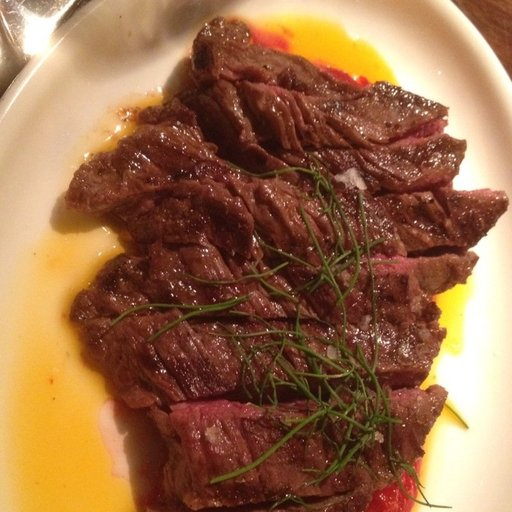

In [6]:
import random  # Import the random module for generating random numbers and making random selections
from PIL import Image  # Import the Image class from the Pillow library for image processing

# Set seed for reproducibility
random.seed(42)  # Setting the seed ensures that the random selections are the same every time the code is run


# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))
# Use the glob method from pathlib.Path to find all JPEG images in any subdirectory two levels deep using */*/*.jpg
# For example, it will match paths like "train/pizza/pizza1.jpg" or "test/steak/steak2.jpg"
# Convert the generator returned by glob into a list for easy access

# 2. Get random image path
random_image_path = random.choice(image_path_list)  # Select a random image path from the list for random sampling of images from the dataset

# 3. Get image class from path name
image_class = random_image_path.parent.stem     # Access the parent directory of the image file and get its name (stem) without the file extension
# For example, if the path is "train/pizza/pizza1.jpg", the class is "pizza"

# 4. Open image
img = Image.open(random_image_path)     # Open the image file using Pillow's Image class which provides further processing or analysis of the image

# 5. Print metadata using PIL library
print(f"Random image path: {random_image_path}")    # Display the full path of the randomly selected image

print(f"Image class: {image_class}")    # Display the class/category of the image (e.g., pizza, steak, sushi)

print(f"Image height: {img.height}")    # Display the height of the image in pixels

print(f"Image width: {img.width}")  # Display the width of the image in pixels

img
# In Jupyter notebooks, placing the image object at the end will render and display the image

# image_path_list # uncomment this line if you want to see image paths

We can do the same with [`matplotlib.pyplot.imshow()`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html), except we have to convert the image to a NumPy array first.

(-0.5, 511.5, 511.5, -0.5)

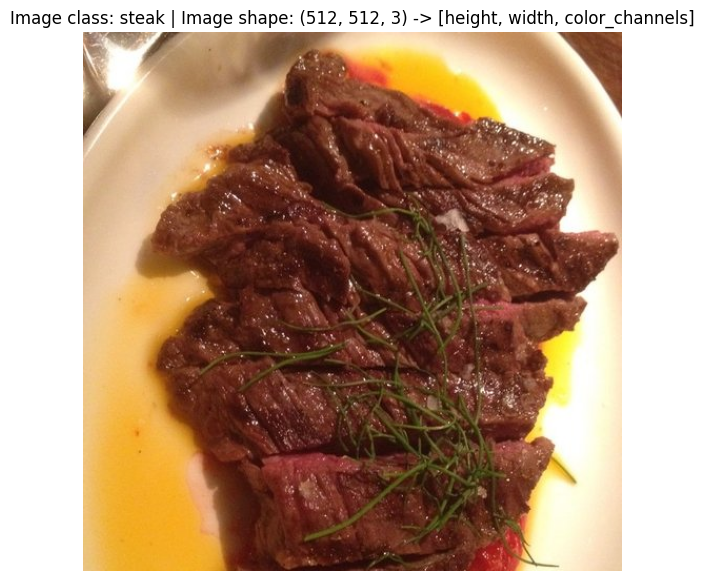

In [7]:
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting images

# Turn the image into a NumPy array
img_as_array = np.asarray(img)

# Plot the image using matplotlib
plt.figure(figsize=(10, 7))  # Set the figure size
plt.imshow(img_as_array)  # Display the image array
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
# Set the plot title with image class and shape details
plt.axis(False)  # Hide the axis for a cleaner look

## 3. Transforming data



Now what if we wanted to load our image data into PyTorch?

Before we can use our image data with PyTorch we need to:

1. Turn it into tensors (numerical representations of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader` for short.

There are several different kinds of pre-built datasets and dataset loaders for PyTorch, depending on the problem you're working on.

| **Problem space** | **Pre-built Datasets and Functions** |
| ----- | ----- |
| **Vision** | [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) |
| **Audio** | [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html) |
| **Text** | [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html) |
| **Recommendation system** | [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html) |

Since we're working with a vision problem, we'll be looking at `torchvision.datasets` for our data loading functions as well as [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) for preparing our data.

Let's import some base libraries.

In [8]:
import torch
from torch.utils.data import DataLoader  # DataLoader will help us to load the data in batches
from torchvision import datasets, transforms    # datasets is for pre-defined datasets, transforms is for image transformations

### 3.1 Transforming data with `torchvision.transforms`



We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors.

One of the ways we can do this is by using the `torchvision.transforms` module.

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for **data augmentation** (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes .

To get experience with `torchvision.transforms`, let's write a series of transform steps that:
1. Resize the images using [`transforms.Resize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize) (from about 512x512 to 64x64, the same shape as the images on the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/)).
2. Flip our images randomly on the horizontal using [`transforms.RandomHorizontalFlip()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip) (this could be considered a form of data augmentation because it will artificially change our image data. In other words, this artificially increases the diversity of our dataset).
3. Turn our images from a PIL image to a PyTorch tensor using [`transforms.ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor).

We can compile all of these steps using [`torchvision.transforms.Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose).

In [9]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

#data_transform(img) # uncomment this to output tensors
data_transform(img).shape # uncomment this to output tensor shape


torch.Size([3, 64, 64])

### Code Explanation





#### 64x64
- **Reason for 64x64**: Resizing images to 64x64 pixels standardizes the input size, which is essential for training neural networks. This size is a balance between maintaining sufficient detail for the model to learn meaningful features and reducing computational complexity. While 64x64 is somewhat arbitrary, it is commonly used for smaller-scale projects and experiments. Depending on the specific application and dataset, different sizes (e.g., 32x32, 128x128) might be more appropriate.

#### transforms

- **Description**: `transforms` is a module from the `torchvision` library that provides a suite of tools for preprocessing and augmenting image data. It allows you to compose several image transformations into a single pipeline, which can be applied to datasets to prepare them for training neural networks.
- **Usage**: By using `transforms.Compose`, multiple transformations can be chained together to be applied sequentially to each image in the dataset.

#### Resize

- **Function**: `transforms.Resize(size=(64, 64))`
- **Purpose**: Resizes the input image to the specified dimensions (64x64 pixels in this case).
- **Why It's Important**:
  - **Uniformity**: Ensures all images have the same dimensions, which is required for batch processing in neural networks.
  - **Computational Efficiency**: Smaller image sizes reduce the amount of data the model needs to process, speeding up training and inference.
- **Considerations**: Choosing the right size depends on the complexity of the task and the available computational resources. Larger sizes retain more detail but require more processing power.

#### RandomHorizontalFlip

- **Function**: `transforms.RandomHorizontalFlip(p=0.5)`
- **Purpose**: Randomly flips the image horizontally with a probability of 50%.
- **Benefits**:
  - **Data Augmentation**: Introduces variability in the training data, which helps the model generalize better to unseen data.
  - **Robustness**: Makes the model invariant to horizontal orientations of objects, improving its ability to recognize objects regardless of their horizontal placement.
- **Parameters**:
  - `p=0.5`: Sets the probability of flipping an image. A value of 0.5 means there's an equal chance for the image to be flipped or left as is.

#### ToTensor

- **Function**: `transforms.ToTensor()`
- **Purpose**: Converts a PIL Image or NumPy `ndarray` into a PyTorch tensor.
- **Key Actions**:
  - **Scaling**: Transforms pixel values from the range [0, 255] to [0.0, 1.0], which is a common preprocessing step for neural networks.
  - **Dimension Adjustment**: Changes the image shape from (H, W, C) to (C, H, W), as PyTorch expects the channel dimension first.
- **Importance**:
  - **Compatibility**: Prepares image data in a format that PyTorch models can process.
  - **Normalization**: Helps in stabilizing and accelerating the training process by ensuring consistent input scales.


Now we've got a composition of transforms, let's write a function to try them out on various images.

### 3.2 `plot_transformed_images` Function

In the previous section, we applied transformations to a single image. In this section, we will extend this approach to transform multiple images simultaneously.

Transforms play a crucial role in preparing your images for model training and performing data augmentation. By applying a series of transformations to batches of images, we can enhance the diversity of our dataset, improve model generalization, and reduce overfitting.

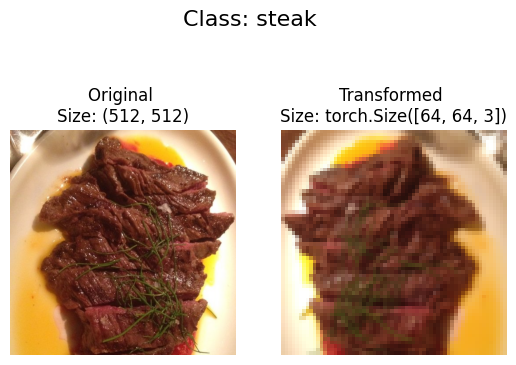

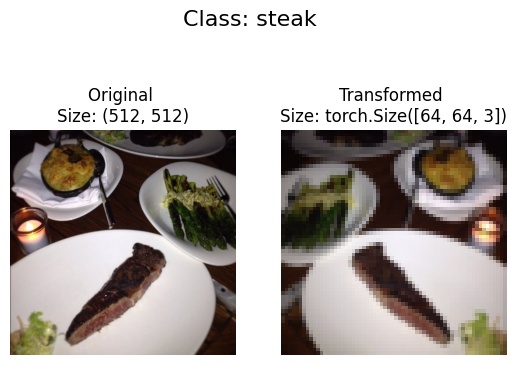

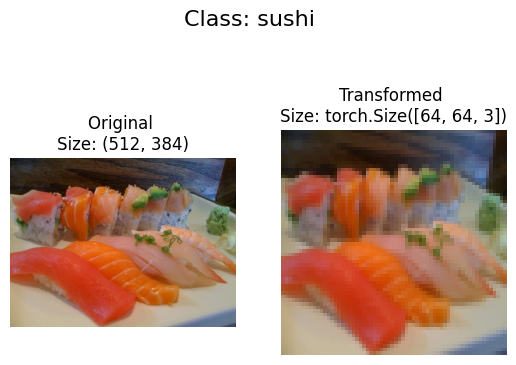

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)                                       # Set the random seed for reproducibility
    random_image_paths = random.sample(image_paths, k=n)    # Select n random image paths from the list
    for image_path in random_image_paths:                   # Iterate over each randomly selected image path
        with Image.open(image_path) as f:                   # Open the image file
            fig, ax = plt.subplots(1, 2)                    # Create a figure with two subplots side by side
            ax[0].imshow(f)                                 # Display the original image in the first subplot
            ax[0].set_title(f"Original \nSize: {f.size}")   # Set the title for the original image subplot
            ax[0].axis("off")                               # Hide the axes for the original image subplot

            # Transform and plot image (original and transformed will be side-by-side)
            # Note: permute() will change shape of image to suit matplotlib

            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)                    # Apply transformations and rearrange dimensions for plotting
            ax[1].imshow(transformed_image)                                      # Display the transformed image in the second subplot
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")    # Set the title for the transformed image subplot
            ax[1].axis("off")                                                    # Hide the axes for the transformed image subplot

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)        # Set the overall title for the figure indicating the image class

plot_transformed_images(         # Plot the transformation
    image_path_list,             # Provide the list of image paths to the function
    transform=data_transform,    # Specify the transformation to apply to images
    n=3                          # Define the number of images
)                                # Call the function to execute the plotting

Nice!

We've now got a way to convert our images to tensors using `torchvision.transforms`.

We also manipulate their size and orientation if needed (some models prefer images of different sizes and shapes).

Generally, the larger the shape of the image, the more information a model can recover.

For example, an image of size `[256, 256, 3]` will have 16x more pixels than an image of size `[64, 64, 3]` (`(256*256*3)/(64*64*3)=16`).

However, the tradeoff is that more pixels requires more computations.

> **Exercise:** Try commenting out one of the transforms in `data_transform` and running the plotting function `plot_transformed_images()` again, what happens?

#### Code Explanation  



- **`Image.open(image_path)`**: This function from the Python Imaging Library (PIL), which is now known as `PIL.Image` or simply `Image`, is used to open and read an image file located at `image_path`. It returns an image object that can be manipulated or displayed.

- **`ax[]`**: In matplotlib, `fig, ax = plt.subplots(1, 2)` creates a figure (`fig`) containing a grid of subplots (axes). The variable `ax` is typically an array-like structure if more than one subplot is created. Here, since we create two subplots side by side (`1, 2`), `ax` will be an array with two elements: `ax[0]` for the first subplot and `ax[1]` for the second subplot. You use these to plot different images or data in each subplot.

- **`transform(f)`**: The `transform` variable is expected to be a PyTorch transform, which is a callable object that applies specified transformations to input data (in this case, an image). When you call `transform(f)`, the image object `f` is passed through the transformation pipeline defined by `transform`. This could involve resizing, cropping, rotating, converting color spaces, etc., as per the transform's configuration.

- **`permute(1, 2, 0)`**: In PyTorch, images are typically represented in a tensor format with dimensions `[C, H, W]`, where `C` is the number of channels (e.g., 3 for RGB), `H` is the height, and `W` is the width. Matplotlib, however, expects images to have dimensions `[H, W, C]`. The `permute(1, 2, 0)` method reorders these dimensions from `[C, H, W]` to `[H, W, C]`, making the image suitable for display using matplotlib.

- **`with something as something:`**: This is a context manager in Python used to wrap the execution of a block of code within methods defined by the context manager. In this case, `with Image.open(image_path) as f:` opens an image file and assigns it to the variable `f`. The advantage of using a context manager here is that it ensures the file is properly closed after its suite finishes, even if an exception is raised during execution. This helps in managing resources efficiently and avoiding leaks.



Continue in `20:59:09`